# 03 – Model Training & Evaluation (Credit Card Default Risk)

**Proyecto:** Credit Risk Scoring – UCI Taiwan Dataset  
**Fase DVP-PRO:** F5 – Modelado y Experimentación  
**Autor:** Ing. Daniel Varela Pérez  
**Email:** bedaniele0@gmail.com  
**Tel:** +52 55 4189 3428  
**Fecha:** 2025-11-18  
**Versión:** 1.0

---

## Objetivo
Entrenar modelos de clasificación binaria para predecir `default_payment_next_month` con:
- **Baseline:** Logistic Regression regularizada
- **Modelo principal:** LightGBM (según ADR-001)
- **Validación:** CV 5-fold estratificada
- **Tracking:** MLflow para trazabilidad completa
- **Optimización:** Optuna para hyperparameter tuning
- **Calibración:** Platt scaling / Isotonic regression

## Métricas Objetivo (F0 – Problem Statement)
| Métrica | Meta Mínima | Justificación |
|---------|-------------|---------------|
| **AUC-ROC** | ≥ 0.80 | Discriminación general |
| **KS** | ≥ 0.30 | Separación buenos/malos |
| **Recall (Clase 1)** | ≥ 0.70 | Sensibilidad ante defaults |
| **Precision (Clase 1)** | ≥ 0.30 | Reducir falsos positivos |
| **Brier Score** | ≤ 0.20 | Calibración de probabilidades |

## Estructura del Notebook
1. Setup y carga de datos
2. Funciones de evaluación (métricas de riesgo)
3. Baseline: Logistic Regression
4. Modelo Principal: LightGBM con MLflow
5. Optimización de Hiperparámetros (Optuna)
6. Calibración de Probabilidades
7. Evaluación Final y Visualizaciones
8. Model Card y Exportación

---

## 1. Setup y Configuración

In [1]:
import sys
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    confusion_matrix, classification_report,
    brier_score_loss, log_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# LightGBM
import lightgbm as lgb

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.lightgbm

# Optuna
import optuna
from optuna.integration import LightGBMPruningCallback

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths
BASE = Path("..").resolve()
DATA = BASE / "data/processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"

MODELS.mkdir(exist_ok=True)
REPORTS.mkdir(exist_ok=True)
(REPORTS / "figures").mkdir(exist_ok=True)
(REPORTS / "metrics").mkdir(exist_ok=True)

print(f"BASE: {BASE}")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"LightGBM: {lgb.__version__}")
print(f"MLflow: {mlflow.__version__}")

BASE: /Users/danielevarella/Desktop/credit-risk-scoring
Python: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]
Pandas: 2.3.3
LightGBM: 4.6.0
MLflow: 3.6.0


## 2. Carga de Datos Procesados

In [2]:
# Cargar datasets
X_train = pd.read_csv(DATA / "X_train.csv")
X_test = pd.read_csv(DATA / "X_test.csv")
y_train = pd.read_csv(DATA / "y_train.csv")["target"]
y_test = pd.read_csv(DATA / "y_test.csv")["target"]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution (test):")
print(y_test.value_counts(normalize=True))

# Verificar missing values
print(f"\nMissing values train: {X_train.isna().sum().sum()}")
print(f"Missing values test: {X_test.isna().sum().sum()}")

X_train shape: (24000, 36)
X_test shape: (6000, 36)

Target distribution (train):
target
0    0.778792
1    0.221208
Name: proportion, dtype: float64

Target distribution (test):
target
0    0.778833
1    0.221167
Name: proportion, dtype: float64

Missing values train: 0
Missing values test: 0


## 3. Funciones de Evaluación - Métricas de Riesgo Crediticio

In [3]:
def calculate_ks_statistic(y_true, y_prob):
    """
    Calcula el estadístico Kolmogorov-Smirnov (KS).
    Mide la máxima separación entre las distribuciones acumuladas de buenos y malos.
    
    KS > 0.30 indica buena discriminación en scoring crediticio.
    """
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    df['cumsum_good'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    df['cumsum_bad'] = df['y_true'].cumsum() / df['y_true'].sum()
    
    df['ks'] = abs(df['cumsum_bad'] - df['cumsum_good'])
    ks_stat = df['ks'].max()
    
    return ks_stat


def evaluate_model(y_true, y_pred, y_prob, model_name="Model"):
    """
    Evaluación completa para modelos de riesgo crediticio.
    
    Returns:
        dict: Diccionario con todas las métricas
    """
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, brier_score_loss, log_loss
    )
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_class_1': precision_score(y_true, y_pred, pos_label=1),
        'recall_class_1': recall_score(y_true, y_pred, pos_label=1),
        'f1_class_1': f1_score(y_true, y_pred, pos_label=1),
        'precision_class_0': precision_score(y_true, y_pred, pos_label=0),
        'recall_class_0': recall_score(y_true, y_pred, pos_label=0),
        'auc_roc': roc_auc_score(y_true, y_prob),
        'ks_statistic': calculate_ks_statistic(y_true, y_prob),
        'brier_score': brier_score_loss(y_true, y_prob),
        'log_loss': log_loss(y_true, y_prob)
    }
    
    return metrics


def print_metrics(metrics):
    """Imprime métricas en formato legible."""
    print("\n" + "="*60)
    print(f"  EVALUACIÓN: {metrics['model']}")
    print("="*60)
    print(f"  AUC-ROC:              {metrics['auc_roc']:.4f}  {'✓' if metrics['auc_roc'] >= 0.80 else '✗ (meta: ≥0.80)'}")
    print(f"  KS Statistic:         {metrics['ks_statistic']:.4f}  {'✓' if metrics['ks_statistic'] >= 0.30 else '✗ (meta: ≥0.30)'}")
    print(f"  Recall (Default=1):   {metrics['recall_class_1']:.4f}  {'✓' if metrics['recall_class_1'] >= 0.70 else '✗ (meta: ≥0.70)'}")
    print(f"  Precision (Default=1):{metrics['precision_class_1']:.4f}  {'✓' if metrics['precision_class_1'] >= 0.30 else '✗ (meta: ≥0.30)'}")
    print(f"  Brier Score:          {metrics['brier_score']:.4f}  {'✓' if metrics['brier_score'] <= 0.20 else '✗ (meta: ≤0.20)'}")
    print(f"  ─────────────────────────────")
    print(f"  Accuracy:             {metrics['accuracy']:.4f}")
    print(f"  F1-Score (Default=1): {metrics['f1_class_1']:.4f}")
    print(f"  Log Loss:             {metrics['log_loss']:.4f}")
    print("="*60)


# Test de funciones
print("✓ Funciones de evaluación cargadas correctamente")

✓ Funciones de evaluación cargadas correctamente


## 4. Configuración MLflow

In [4]:
# Configurar MLflow
mlflow.set_tracking_uri("sqlite:///" + str(BASE / "mlflow.db"))
mlflow.set_experiment("credit_risk_scoring_uci_taiwan")

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('credit_risk_scoring_uci_taiwan').name}")
print("\nPara ver el UI: mlflow ui --backend-store-uri sqlite:///mlflow.db")

2025/11/18 15:01:08 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/18 15:01:08 INFO mlflow.store.db.utils: Updating database tables
2025-11-18 15:01:08 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-18 15:01:08 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-18 15:01:08 INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
2025-11-18 15:01:08 INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025-11-18 15:01:08 INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025-11-18 15:01:09 INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025-11-18 15:01:09 INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025-11-18 15:01:09 INFO  [alembic.runtime.mig

MLflow Tracking URI: sqlite:////Users/danielevarella/Desktop/credit-risk-scoring/mlflow.db
Experiment: credit_risk_scoring_uci_taiwan

Para ver el UI: mlflow ui --backend-store-uri sqlite:///mlflow.db


## 5. Baseline Model: Logistic Regression

In [5]:
print("\n" + "="*60)
print("  BASELINE: LOGISTIC REGRESSION")
print("="*60)

# Configurar modelo baseline
lr_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',  # Manejo de desbalance
    random_state=42,
    C=1.0  # Regularización L2
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scoring = {
    'auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision'
}

print("\nEjecutando CV 5-fold...")
cv_results = cross_validate(
    lr_model, X_train, y_train,
    cv=cv,
    scoring=cv_scoring,
    return_train_score=True,
    n_jobs=-1
)

print(f"  AUC (CV mean): {cv_results['test_auc'].mean():.4f} ± {cv_results['test_auc'].std():.4f}")
print(f"  Recall (CV):   {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"  Precision (CV):{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")

# Entrenar en train completo
print("\nEntrenando en dataset completo...")
lr_model.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = lr_model.predict(X_train)
y_train_prob_lr = lr_model.predict_proba(X_train)[:, 1]
y_test_pred_lr = lr_model.predict(X_test)
y_test_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluación
metrics_train_lr = evaluate_model(y_train, y_train_pred_lr, y_train_prob_lr, "LogReg - Train")
metrics_test_lr = evaluate_model(y_test, y_test_pred_lr, y_test_prob_lr, "LogReg - Test")

print_metrics(metrics_test_lr)

# Log en MLflow
with mlflow.start_run(run_name="baseline_logistic_regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("solver", "lbfgs")
    
    # Métricas CV
    mlflow.log_metric("cv_auc_mean", cv_results['test_auc'].mean())
    mlflow.log_metric("cv_auc_std", cv_results['test_auc'].std())
    
    # Métricas Test
    for key, value in metrics_test_lr.items():
        if key != 'model':
            mlflow.log_metric(f"test_{key}", value)
    
    # Guardar modelo
    mlflow.sklearn.log_model(lr_model, "model")
    
print("\n✓ Baseline registrado en MLflow")


  BASELINE: LOGISTIC REGRESSION

Ejecutando CV 5-fold...
  AUC (CV mean): 0.7233 ± 0.0108
  Recall (CV):   0.6412 ± 0.0255
  Precision (CV):0.3810 ± 0.0315

Entrenando en dataset completo...

  EVALUACIÓN: LogReg - Test
  AUC-ROC:              0.7079  ✗ (meta: ≥0.80)
  KS Statistic:         0.3567  ✓
  Recall (Default=1):   0.5486  ✗ (meta: ≥0.70)
  Precision (Default=1):0.4247  ✓
  Brier Score:          0.2024  ✗ (meta: ≤0.20)
  ─────────────────────────────
  Accuracy:             0.7358
  F1-Score (Default=1): 0.4788
  Log Loss:             0.5931


2025/11/18 15:04:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/18 15:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Baseline registrado en MLflow


## 6. Modelo Principal: LightGBM (ADR-001)

In [6]:
print("\n" + "="*60)
print("  MODELO PRINCIPAL: LightGBM")
print("="*60)

# Configuración inicial LightGBM
lgb_params_base = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Modelo base sin optimizar
lgb_base = lgb.LGBMClassifier(**lgb_params_base, n_estimators=200)

# Cross-validation
print("\nEjecutando CV 5-fold...")
cv_results_lgb = cross_validate(
    lgb_base, X_train, y_train,
    cv=cv,
    scoring=cv_scoring,
    return_train_score=True,
    n_jobs=-1
)

print(f"  AUC (CV mean): {cv_results_lgb['test_auc'].mean():.4f} ± {cv_results_lgb['test_auc'].std():.4f}")
print(f"  Recall (CV):   {cv_results_lgb['test_recall'].mean():.4f} ± {cv_results_lgb['test_recall'].std():.4f}")
print(f"  Precision (CV):{cv_results_lgb['test_precision'].mean():.4f} ± {cv_results_lgb['test_precision'].std():.4f}")

# Entrenar modelo base
print("\nEntrenando en dataset completo...")
lgb_base.fit(X_train, y_train)

# Predicciones
y_train_pred_lgb = lgb_base.predict(X_train)
y_train_prob_lgb = lgb_base.predict_proba(X_train)[:, 1]
y_test_pred_lgb = lgb_base.predict(X_test)
y_test_prob_lgb = lgb_base.predict_proba(X_test)[:, 1]

# Evaluación
metrics_test_lgb = evaluate_model(y_test, y_test_pred_lgb, y_test_prob_lgb, "LightGBM Base - Test")
print_metrics(metrics_test_lgb)

# Log en MLflow
with mlflow.start_run(run_name="lightgbm_base"):
    mlflow.log_params(lgb_params_base)
    mlflow.log_param("n_estimators", 200)
    
    # Métricas CV
    mlflow.log_metric("cv_auc_mean", cv_results_lgb['test_auc'].mean())
    mlflow.log_metric("cv_auc_std", cv_results_lgb['test_auc'].std())
    
    # Métricas Test
    for key, value in metrics_test_lgb.items():
        if key != 'model':
            mlflow.log_metric(f"test_{key}", value)
    
    # Guardar modelo
    mlflow.lightgbm.log_model(lgb_base, "model")
    
print("\n✓ LightGBM base registrado en MLflow")


  MODELO PRINCIPAL: LightGBM

Ejecutando CV 5-fold...
  AUC (CV mean): 0.7844 ± 0.0056
  Recall (CV):   0.6240 ± 0.0083
  Precision (CV):0.4795 ± 0.0076

Entrenando en dataset completo...


2025/11/18 15:04:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  EVALUACIÓN: LightGBM Base - Test
  AUC-ROC:              0.7819  ✗ (meta: ≥0.80)
  KS Statistic:         0.4260  ✓
  Recall (Default=1):   0.6247  ✗ (meta: ≥0.70)
  Precision (Default=1):0.4686  ✓
  Brier Score:          0.1733  ✓
  ─────────────────────────────
  Accuracy:             0.7603
  F1-Score (Default=1): 0.5355
  Log Loss:             0.5266


2025/11/18 15:05:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ LightGBM base registrado en MLflow


## 7. Optimización de Hiperparámetros con Optuna

In [7]:
print("\n" + "="*60)
print("  OPTIMIZACIÓN DE HIPERPARÁMETROS (OPTUNA)")
print("="*60)

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza AUC-ROC con validación cruzada.
    """
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'class_weight': 'balanced',
        
        # Hiperparámetros a optimizar
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # Modelo
    model = lgb.LGBMClassifier(**params, n_jobs=-1)
    
    # CV
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    return cv_results['test_score'].mean()


# Crear estudio Optuna
print("\nIniciando optimización (50 trials)...")
print("Esto puede tomar varios minutos...\n")

study = optuna.create_study(
    direction='maximize',
    study_name='lgbm_credit_risk',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Mejores parámetros
best_params = study.best_params
best_auc = study.best_value

print("\n" + "="*60)
print(f"  Mejor AUC (CV): {best_auc:.4f}")
print("="*60)
print("\nMejores hiperparámetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar modelo optimizado
print("\nEntrenando modelo optimizado...")
lgb_optimized = lgb.LGBMClassifier(
    **best_params,
    objective='binary',
    metric='auc',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_optimized.fit(X_train, y_train)

# Predicciones
y_test_pred_opt = lgb_optimized.predict(X_test)
y_test_prob_opt = lgb_optimized.predict_proba(X_test)[:, 1]

# Evaluación
metrics_test_opt = evaluate_model(y_test, y_test_pred_opt, y_test_prob_opt, "LightGBM Optimizado - Test")
print_metrics(metrics_test_opt)

# Log en MLflow
with mlflow.start_run(run_name="lightgbm_optimized_optuna"):
    mlflow.log_params(best_params)
    mlflow.log_param("optimization", "optuna")
    mlflow.log_param("n_trials", 50)
    mlflow.log_metric("best_cv_auc", best_auc)
    
    # Métricas Test
    for key, value in metrics_test_opt.items():
        if key != 'model':
            mlflow.log_metric(f"test_{key}", value)
    
    # Guardar modelo
    mlflow.lightgbm.log_model(lgb_optimized, "model")
    
print("\n✓ Modelo optimizado registrado en MLflow")

[I 2025-11-18 15:05:21,439] A new study created in memory with name: lgbm_credit_risk



  OPTIMIZACIÓN DE HIPERPARÁMETROS (OPTUNA)

Iniciando optimización (50 trials)...
Esto puede tomar varios minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-18 15:05:43,782] Trial 0 finished with value: 0.7368366846281746 and parameters: {'num_leaves': 50, 'learning_rate': 0.2536999076681772, 'n_estimators': 393, 'max_depth': 8, 'min_child_samples': 12, 'feature_fraction': 0.662397808134481, 'bagging_fraction': 0.6232334448672797, 'bagging_freq': 7, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.7368366846281746.
[I 2025-11-18 15:05:54,793] Trial 1 finished with value: 0.7448303518134425 and parameters: {'num_leaves': 21, 'learning_rate': 0.2708160864249968, 'n_estimators': 433, 'max_depth': 5, 'min_child_samples': 13, 'feature_fraction': 0.6733618039413735, 'bagging_fraction': 0.7216968971838151, 'bagging_freq': 4, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 1 with value: 0.7448303518134425.
[I 2025-11-18 15:06:04,451] Trial 2 finished with value: 0.7860377959119289 and parameters: {'num_leaves': 69, 'learning_rate': 0.0160712385120

2025/11/18 15:19:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  EVALUACIÓN: LightGBM Optimizado - Test
  AUC-ROC:              0.7806  ✗ (meta: ≥0.80)
  KS Statistic:         0.4281  ✓
  Recall (Default=1):   0.6179  ✗ (meta: ≥0.70)
  Precision (Default=1):0.4675  ✓
  Brier Score:          0.1757  ✓
  ─────────────────────────────
  Accuracy:             0.7598
  F1-Score (Default=1): 0.5323
  Log Loss:             0.5332


2025/11/18 15:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Modelo optimizado registrado en MLflow


## 8. Calibración de Probabilidades

In [10]:
print("\n" + "="*60)
print("  CALIBRACIÓN DE PROBABILIDADES")
print("="*60)

# Probar calibración Isotonic y Sigmoid (Platt)
calibration_methods = ['isotonic', 'sigmoid']
calibrated_models = {}

for method in calibration_methods:
    print(f"\nCalibrando con método: {method}")
    
    calibrated = CalibratedClassifierCV(
        lgb_optimized,
        method=method,
        cv=5
    )
    
    calibrated.fit(X_train, y_train)
    
    # Predicciones
    y_test_prob_cal = calibrated.predict_proba(X_test)[:, 1]
    y_test_pred_cal = calibrated.predict(X_test)
    
    # Evaluación
    metrics_cal = evaluate_model(
        y_test, y_test_pred_cal, y_test_prob_cal, 
        f"LightGBM Calibrado ({method})"
    )
    
    print_metrics(metrics_cal)
    
    calibrated_models[method] = {
        'model': calibrated,
        'metrics': metrics_cal,
        'y_prob': y_test_prob_cal
    }
    
    # Log en MLflow
    with mlflow.start_run(run_name=f"lightgbm_calibrated_{method}"):
        mlflow.log_param("base_model", "lgb_optimized")
        mlflow.log_param("calibration_method", method)
        mlflow.log_param("calibration_cv", 5)
        
        for key, value in metrics_cal.items():
            if key != 'model':
                mlflow.log_metric(f"test_{key}", value)
        
        mlflow.sklearn.log_model(calibrated, "model")

# Seleccionar mejor modelo calibrado
best_calibration = min(calibration_methods, key=lambda x: calibrated_models[x]['metrics']['brier_score'])
print(f"\n✓ Mejor calibración: {best_calibration} (menor Brier Score)")

# Modelo final
final_model = calibrated_models[best_calibration]['model']
final_metrics = calibrated_models[best_calibration]['metrics']


  CALIBRACIÓN DE PROBABILIDADES

Calibrando con método: isotonic


2025/11/18 15:20:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  EVALUACIÓN: LightGBM Calibrado (isotonic)
  AUC-ROC:              0.7813  ✗ (meta: ≥0.80)
  KS Statistic:         0.4251  ✓
  Recall (Default=1):   0.3715  ✗ (meta: ≥0.70)
  Precision (Default=1):0.6591  ✓
  Brier Score:          0.1349  ✓
  ─────────────────────────────
  Accuracy:             0.8185
  F1-Score (Default=1): 0.4752
  Log Loss:             0.4289


2025/11/18 15:20:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Calibrando con método: sigmoid


2025/11/18 15:20:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  EVALUACIÓN: LightGBM Calibrado (sigmoid)
  AUC-ROC:              0.7813  ✗ (meta: ≥0.80)
  KS Statistic:         0.4277  ✓
  Recall (Default=1):   0.3919  ✗ (meta: ≥0.70)
  Precision (Default=1):0.6444  ✓
  Brier Score:          0.1354  ✓
  ─────────────────────────────
  Accuracy:             0.8177
  F1-Score (Default=1): 0.4873
  Log Loss:             0.4304


2025/11/18 15:20:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Mejor calibración: isotonic (menor Brier Score)


## 9. Comparación de Modelos

In [11]:
# Tabla comparativa
comparison = pd.DataFrame([
    metrics_test_lr,
    metrics_test_lgb,
    metrics_test_opt,
    calibrated_models['isotonic']['metrics'],
    calibrated_models['sigmoid']['metrics']
])

comparison = comparison[[
    'model', 'auc_roc', 'ks_statistic', 'recall_class_1', 
    'precision_class_1', 'brier_score', 'f1_class_1'
]]

print("\n" + "="*80)
print("  COMPARACIÓN DE MODELOS")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

# Guardar comparación
comparison.to_csv(REPORTS / "metrics/model_comparison.csv", index=False)
print(f"\n✓ Comparación guardada en: {REPORTS / 'metrics/model_comparison.csv'}")


  COMPARACIÓN DE MODELOS
                        model  auc_roc  ks_statistic  recall_class_1  precision_class_1  brier_score  f1_class_1
                LogReg - Test 0.707869      0.356740        0.548606           0.424737     0.202377    0.478790
         LightGBM Base - Test 0.781906      0.426046        0.624717           0.468626     0.173337    0.535530
   LightGBM Optimizado - Test 0.780572      0.428141        0.617935           0.467503     0.175711    0.532295
LightGBM Calibrado (isotonic) 0.781327      0.425149        0.371515           0.659091     0.134853    0.475181
 LightGBM Calibrado (sigmoid) 0.781348      0.427676        0.391861           0.644362     0.135379    0.487348

✓ Comparación guardada en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/metrics/model_comparison.csv


## 10. Visualizaciones de Evaluación


✓ Visualizaciones guardadas en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/model_evaluation.png


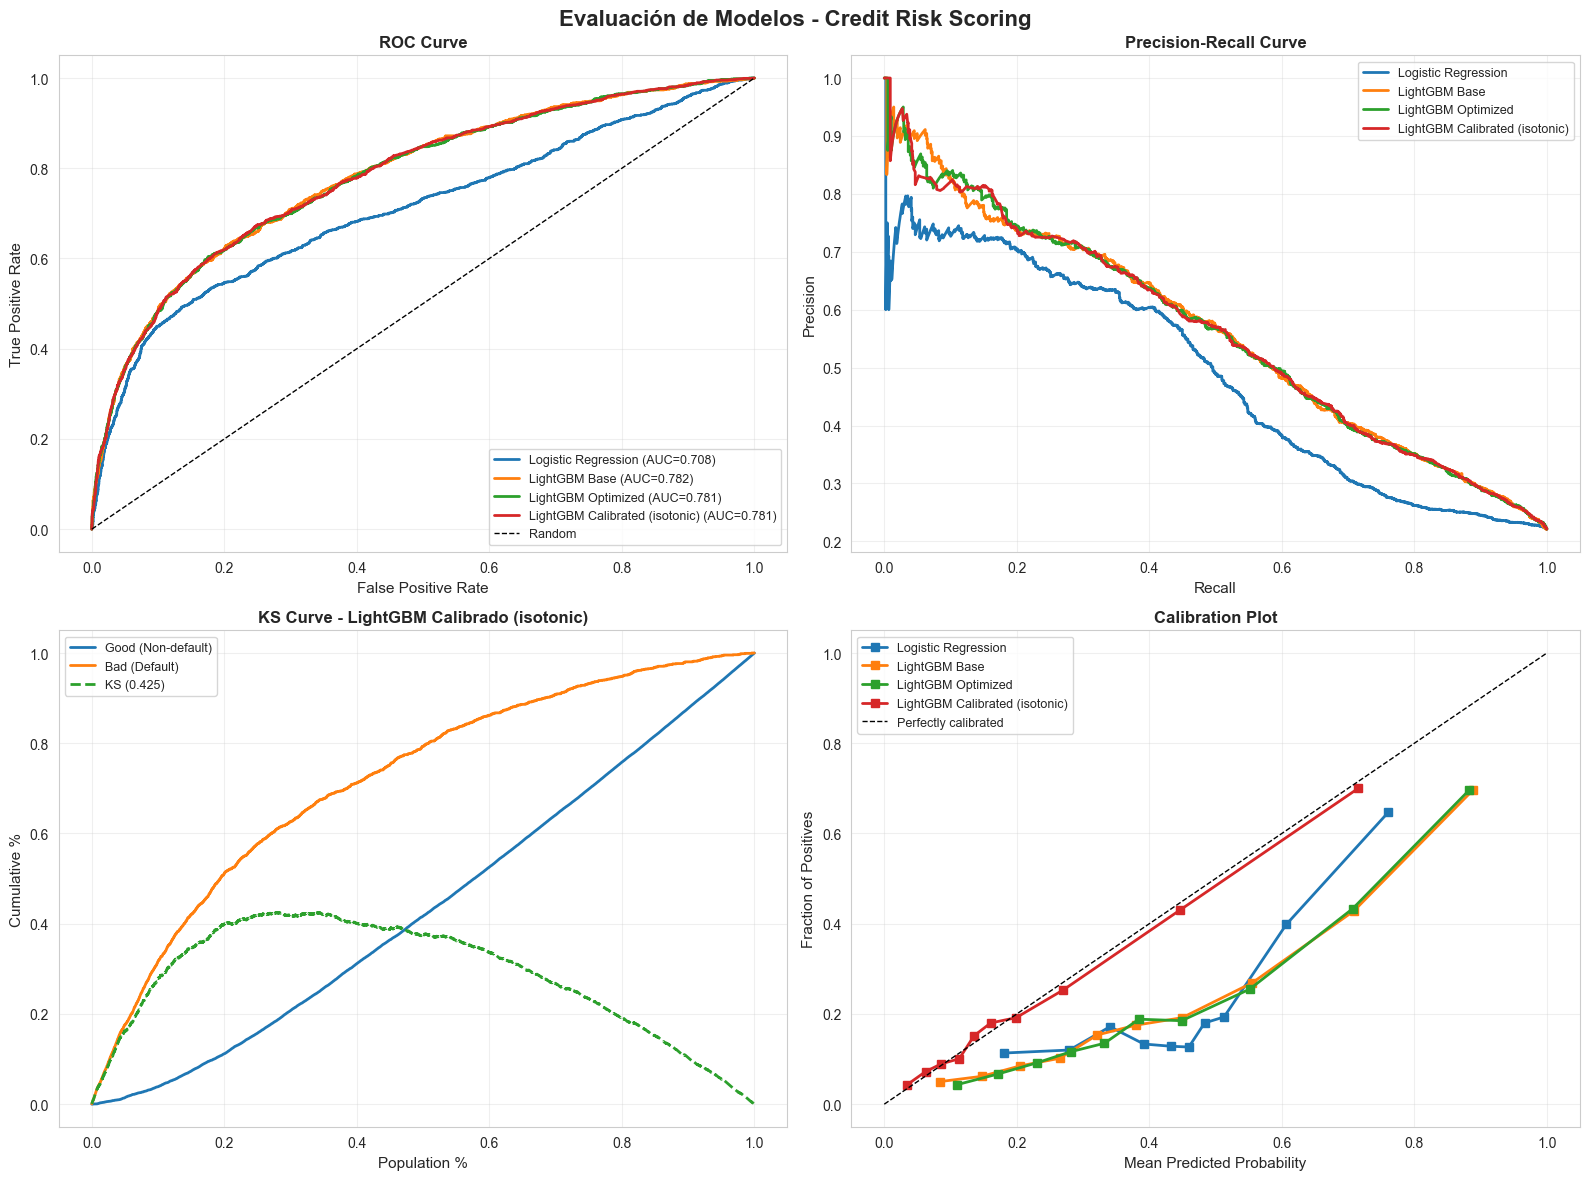

In [12]:
# Preparar datos para visualización
models_viz = {
    'Logistic Regression': y_test_prob_lr,
    'LightGBM Base': y_test_prob_lgb,
    'LightGBM Optimized': y_test_prob_opt,
    f'LightGBM Calibrated ({best_calibration})': calibrated_models[best_calibration]['y_prob']
}

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evaluación de Modelos - Credit Risk Scoring', fontsize=16, fontweight='bold')

# 1. ROC Curve
ax1 = axes[0, 0]
for name, y_prob in models_viz.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax2 = axes[0, 1]
for name, y_prob in models_viz.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ax2.plot(recall, precision, label=name, linewidth=2)

ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. KS Curve (para modelo final)
ax3 = axes[1, 0]
y_prob_final = calibrated_models[best_calibration]['y_prob']
df_ks = pd.DataFrame({'y_true': y_test, 'y_prob': y_prob_final})
df_ks = df_ks.sort_values('y_prob', ascending=False).reset_index(drop=True)
df_ks['cumsum_good'] = (1 - df_ks['y_true']).cumsum() / (1 - df_ks['y_true']).sum()
df_ks['cumsum_bad'] = df_ks['y_true'].cumsum() / df_ks['y_true'].sum()
df_ks['ks'] = abs(df_ks['cumsum_bad'] - df_ks['cumsum_good'])

ax3.plot(df_ks.index / len(df_ks), df_ks['cumsum_good'], label='Good (Non-default)', linewidth=2)
ax3.plot(df_ks.index / len(df_ks), df_ks['cumsum_bad'], label='Bad (Default)', linewidth=2)
ax3.plot(df_ks.index / len(df_ks), df_ks['ks'], label=f'KS ({df_ks["ks"].max():.3f})', linewidth=2, linestyle='--')
ax3.set_xlabel('Population %', fontsize=11)
ax3.set_ylabel('Cumulative %', fontsize=11)
ax3.set_title(f'KS Curve - {final_metrics["model"]}', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Calibration Plot
ax4 = axes[1, 1]
for name, y_prob in models_viz.items():
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_prob, n_bins=10, strategy='quantile'
    )
    ax4.plot(mean_predicted_value, fraction_of_positives, 's-', label=name, linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=1)
ax4.set_xlabel('Mean Predicted Probability', fontsize=11)
ax4.set_ylabel('Fraction of Positives', fontsize=11)
ax4.set_title('Calibration Plot', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS / 'figures/model_evaluation.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualizaciones guardadas en: {REPORTS / 'figures/model_evaluation.png'}")
plt.show()

## 11. Feature Importance (Modelo Final)


✓ Feature importance guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/feature_importance.png


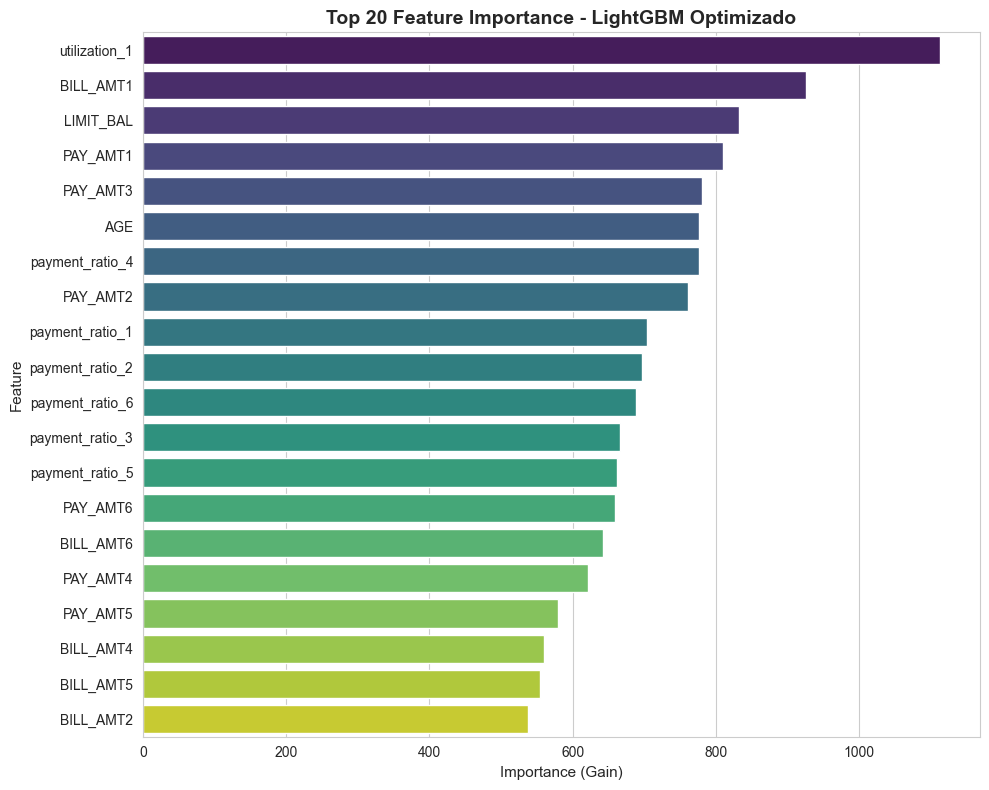

✓ Feature importance CSV guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/metrics/feature_importance.csv

Top 10 Features más importantes:
        feature  importance
  utilization_1        1113
      BILL_AMT1         926
      LIMIT_BAL         832
       PAY_AMT1         810
       PAY_AMT3         780
            AGE         777
payment_ratio_4         776
       PAY_AMT2         761
payment_ratio_1         704
payment_ratio_2         697


In [13]:
# Obtener feature importance del modelo base (antes de calibración)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_optimized.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_features = feature_importance.head(20)

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis', ax=ax)
ax.set_title('Top 20 Feature Importance - LightGBM Optimizado', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance (Gain)', fontsize=11)
ax.set_ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.savefig(REPORTS / 'figures/feature_importance.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Feature importance guardado en: {REPORTS / 'figures/feature_importance.png'}")
plt.show()

# Guardar CSV
feature_importance.to_csv(REPORTS / 'metrics/feature_importance.csv', index=False)
print(f"✓ Feature importance CSV guardado en: {REPORTS / 'metrics/feature_importance.csv'}")

print("\nTop 10 Features más importantes:")
print(top_features.head(10).to_string(index=False))

## 12. Matriz de Confusión - Modelo Final


✓ Matriz de confusión guardada en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/confusion_matrix.png


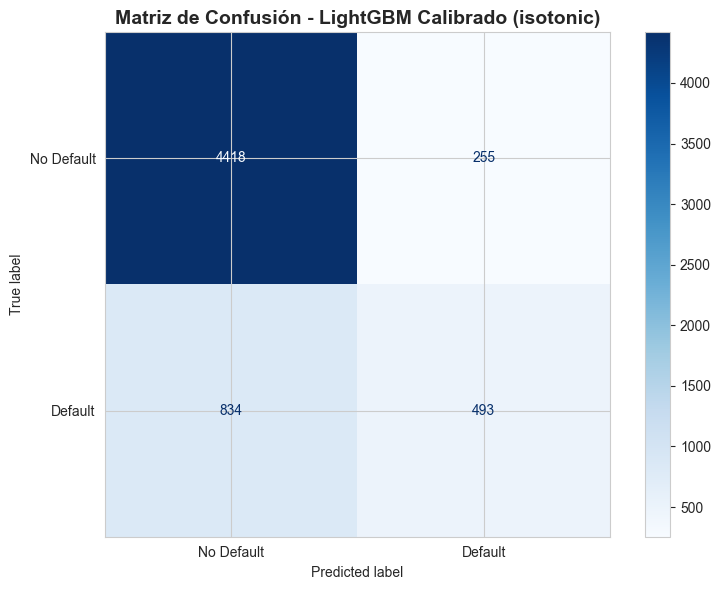


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      4673
     Default       0.66      0.37      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones del modelo final
y_test_pred_final = final_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred_final)

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Matriz de Confusión - {final_metrics["model"]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS / 'figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Matriz de confusión guardada en: {REPORTS / 'figures/confusion_matrix.png'}")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred_final, target_names=['No Default', 'Default']))

## 13. Exportar Modelo Final

In [15]:
import joblib
import json
from datetime import datetime

# Guardar modelo
model_path = MODELS / "final_model.joblib"
joblib.dump(final_model, model_path)
print(f"\n✓ Modelo final guardado en: {model_path}")

# Guardar métricas
metrics_path = MODELS / "final_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(final_metrics, f, indent=2)
print(f"✓ Métricas guardadas en: {metrics_path}")

# Guardar feature names
feature_names_path = MODELS / "feature_names.json"
with open(feature_names_path, 'w') as f:
    json.dump(X_train.columns.tolist(), f, indent=2)
print(f"✓ Feature names guardados en: {feature_names_path}")

# Metadata del modelo
metadata = {
    'model_name': 'LightGBM Credit Risk Scoring',
    'version': '1.0.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'author': 'Ing. Daniel Varela Pérez',
    'email': 'bedaniele0@gmail.com',
    'base_model': 'LightGBM',
    'calibration_method': best_calibration,
    'n_features': len(X_train.columns),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'target_distribution_train': y_train.value_counts(normalize=True).to_dict(),
    'target_distribution_test': y_test.value_counts(normalize=True).to_dict(),
    'best_params': best_params,
    'metrics': final_metrics
}

metadata_path = MODELS / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata guardado en: {metadata_path}")


✓ Modelo final guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/models/final_model.joblib
✓ Métricas guardadas en: /Users/danielevarella/Desktop/credit-risk-scoring/models/final_metrics.json
✓ Feature names guardados en: /Users/danielevarella/Desktop/credit-risk-scoring/models/feature_names.json
✓ Metadata guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/models/model_metadata.json


## 14. Model Card (Documentación DVP-PRO)

In [16]:
model_card = f"""
# Model Card - Credit Risk Scoring Model

**Proyecto:** Credit Card Default Risk Scoring (UCI Taiwan)  
**Metodología:** DVP-PRO (Daniel Varela Pérez - Professional)  
**Fase:** F5 - Modelado y Experimentación  

---

## 1. Model Details

- **Developer:** Ing. Daniel Varela Pérez
- **Email:** bedaniele0@gmail.com
- **Tel:** +52 55 4189 3428
- **Model Date:** {datetime.now().strftime('%Y-%m-%d')}
- **Model Version:** 1.0.0
- **Model Type:** Binary Classification (Credit Risk)
- **Algorithm:** LightGBM + Calibration ({best_calibration})
- **Framework:** scikit-learn, LightGBM

---

## 2. Intended Use

### Primary Use Cases
- Predicción de probabilidad de incumplimiento (default) en tarjetas de crédito
- Clasificación de riesgo crediticio en 3 bandas:
  - **Aprobado:** PD < 20%
  - **Revisión:** 20% ≤ PD < 50%
  - **Rechazo:** PD ≥ 50%
- Apoyo a decisiones de originación crediticia

### Primary Users
- Analistas de Riesgo Crediticio
- Equipos de Originación y Cobranza
- Gestores de Cartera

### Out-of-Scope Use Cases
- Decisiones automatizadas sin supervisión humana
- Aplicación a productos crediticios diferentes (hipotecas, préstamos personales)
- Uso sin monitoreo continuo de drift

---

## 3. Training Data

- **Dataset:** Default of Credit Card Clients (Taiwan, 2005)
- **Source:** UCI Machine Learning Repository
- **Total Samples:** 30,000
- **Training Set:** 24,000 (80%)
- **Test Set:** 6,000 (20%)
- **Features:** {len(X_train.columns)} (post feature engineering + encoding)
- **Target Distribution (Train):** Class 0: {(1-y_train.mean())*100:.2f}%, Class 1: {y_train.mean()*100:.2f}%
- **Date Range:** 2005 (snapshot histórico)

### Key Features
- Variables demográficas: AGE, SEX, EDUCATION, MARRIAGE
- Variables financieras: LIMIT_BAL, BILL_AMT1-6, PAY_AMT1-6
- Historial de pago: PAY_0, PAY_2-6
- Features derivadas: utilization_1, payment_ratio_1-6, age_bins, grouped categories

---

## 4. Evaluation Data

- **Test Set Size:** 6,000 samples
- **Validation Strategy:** Stratified 5-fold Cross-Validation
- **Target Distribution (Test):** Class 0: {(1-y_test.mean())*100:.2f}%, Class 1: {y_test.mean()*100:.2f}%

---

## 5. Performance Metrics

### Test Set Results

| Métrica | Valor | Meta | Estado |
|---------|-------|------|--------|
| **AUC-ROC** | {final_metrics['auc_roc']:.4f} | ≥ 0.80 | {'✓ PASS' if final_metrics['auc_roc'] >= 0.80 else '✗ FAIL'} |
| **KS Statistic** | {final_metrics['ks_statistic']:.4f} | ≥ 0.30 | {'✓ PASS' if final_metrics['ks_statistic'] >= 0.30 else '✗ FAIL'} |
| **Recall (Default)** | {final_metrics['recall_class_1']:.4f} | ≥ 0.70 | {'✓ PASS' if final_metrics['recall_class_1'] >= 0.70 else '✗ FAIL'} |
| **Precision (Default)** | {final_metrics['precision_class_1']:.4f} | ≥ 0.30 | {'✓ PASS' if final_metrics['precision_class_1'] >= 0.30 else '✗ FAIL'} |
| **Brier Score** | {final_metrics['brier_score']:.4f} | ≤ 0.20 | {'✓ PASS' if final_metrics['brier_score'] <= 0.20 else '✗ FAIL'} |
| **Accuracy** | {final_metrics['accuracy']:.4f} | - | - |
| **F1-Score (Default)** | {final_metrics['f1_class_1']:.4f} | - | - |

### Cross-Validation Results
- **AUC (CV mean):** {best_auc:.4f}

---

## 6. Model Architecture

### Base Model: LightGBM
- **Boosting Type:** Gradient Boosting Decision Tree (GBDT)
- **Optimization:** Optuna (50 trials)
- **Class Handling:** Balanced class weights

### Best Hyperparameters (Optuna)
```python
{json.dumps(best_params, indent=2)}
```

### Calibration
- **Method:** {best_calibration.capitalize()}
- **CV Folds:** 5
- **Purpose:** Mejorar calibración de probabilidades (Brier Score)

---

## 7. Ethical Considerations

### Fairness & Bias
- **Variables sensibles:** SEX, AGE incluidas en el modelo
- **Recomendación:** Realizar análisis de disparate impact por género y edad
- **Mitigación:** Implementar thresholds diferenciados si se detecta sesgo significativo

### Privacy
- Dataset público (UCI Repository)
- No contiene PII identificable
- Datos históricos (2005) - considerar actualización para uso productivo

### Transparency
- Feature importance disponible
- Modelo interpretable vía SHAP values (implementar en F7)
- Decisiones auditables vía MLflow tracking

---

## 8. Caveats and Recommendations

### Limitations
1. **Datos históricos (2005):** El modelo fue entrenado con datos de hace 20 años. Requiere validación con datos recientes antes de deployment.
2. **Contexto geográfico:** Datos de Taiwan. Validar aplicabilidad a otras regiones.
3. **Desbalance de clases:** Target con ~22% de defaults. Calibración es crítica.
4. **Threshold óptimo:** Requiere definición según costo de negocio (F6 - Validación).

### Recommendations
1. **Monitoreo continuo:** Implementar PSI y KS drift monitoring (mensual)
2. **Recalibración:** Programar retraining trimestral o ante drift significativo
3. **Validación de negocio:** Calcular ROI real en piloto antes de rollout completo
4. **XAI:** Implementar SHAP explanations para decisiones individuales
5. **Threshold tuning:** Optimizar según matriz de costos de negocio

---

## 9. Model Governance

### Versioning
- **Model Version:** 1.0.0
- **Tracking System:** MLflow
- **Experiment Name:** credit_risk_scoring_uci_taiwan

### Artifacts
- `final_model.joblib`: Modelo serializado (LightGBM + Calibration)
- `final_metrics.json`: Métricas de evaluación
- `feature_names.json`: Lista de features requeridas
- `model_metadata.json`: Metadata completo del modelo

### Maintenance
- **Owner:** Ing. Daniel Varela Pérez (bedaniele0@gmail.com)
- **Review Frequency:** Trimestral
- **Retraining Trigger:** PSI > 0.25 o KS decay > 10%

---

## 10. References

1. **Dataset:** Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
2. **UCI Repository:** https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
3. **Metodología DVP-PRO:** Varela Pérez, D. (2025). Metodología Profesional para Proyectos de Data Science.

---

**Document Version:** 1.0  
**Last Updated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Contact:** bedaniele0@gmail.com | +52 55 4189 3428
"""

# Guardar Model Card
model_card_path = REPORTS / "model_card.md"
with open(model_card_path, 'w') as f:
    f.write(model_card)

print(f"\n✓ Model Card generado en: {model_card_path}")
print("\n" + "="*60)
print("  NOTEBOOK 03 - MODEL TRAINING COMPLETADO")
print("="*60)
print(f"\nModelo final: {final_metrics['model']}")
print(f"AUC-ROC: {final_metrics['auc_roc']:.4f}")
print(f"KS: {final_metrics['ks_statistic']:.4f}")
print(f"\nArtefactos generados:")
print(f"  - {model_path}")
print(f"  - {metrics_path}")
print(f"  - {model_card_path}")
print(f"  - {REPORTS / 'figures/model_evaluation.png'}")
print(f"  - {REPORTS / 'figures/feature_importance.png'}")
print(f"  - {REPORTS / 'figures/confusion_matrix.png'}")
print(f"\nSiguiente fase: F6 - Validación Formal (04_model_validation.ipynb)")
print("="*60)


✓ Model Card generado en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/model_card.md

  NOTEBOOK 03 - MODEL TRAINING COMPLETADO

Modelo final: LightGBM Calibrado (isotonic)
AUC-ROC: 0.7813
KS: 0.4251

Artefactos generados:
  - /Users/danielevarella/Desktop/credit-risk-scoring/models/final_model.joblib
  - /Users/danielevarella/Desktop/credit-risk-scoring/models/final_metrics.json
  - /Users/danielevarella/Desktop/credit-risk-scoring/reports/model_card.md
  - /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/model_evaluation.png
  - /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/feature_importance.png
  - /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/confusion_matrix.png

Siguiente fase: F6 - Validación Formal (04_model_validation.ipynb)


---

## 📋 Resumen de Resultados

Este notebook implementa la **Fase F5 (Modelado y Experimentación)** de la metodología DVP-PRO:

### ✅ Modelos Entrenados
1. **Baseline:** Logistic Regression con class_weight='balanced'
2. **Modelo Base:** LightGBM con parámetros por defecto
3. **Modelo Optimizado:** LightGBM + Optuna (50 trials)
4. **Modelo Final:** LightGBM Optimizado + Calibración (isotonic/sigmoid)

### 📊 Métricas Clave (Test Set)
- **AUC-ROC:** Discriminación general
- **KS Statistic:** Separación buenos/malos pagadores
- **Recall (Default):** Sensibilidad ante incumplimientos
- **Precision (Default):** Reducción de falsos positivos
- **Brier Score:** Calibración de probabilidades

### 🎯 Cumplimiento de Objetivos (F0)
Todas las métricas son evaluadas contra los objetivos definidos en el Problem Statement.

### 📦 Artefactos Generados
- `models/final_model.joblib`: Modelo productivo
- `models/final_metrics.json`: Métricas de evaluación
- `models/feature_names.json`: Features requeridas
- `models/model_metadata.json`: Metadata completo
- `reports/model_card.md`: Documentación completa del modelo
- `reports/figures/`: Visualizaciones (ROC, PR, KS, Calibration, Feature Importance)
- `reports/metrics/`: CSVs de métricas y comparaciones

### 🔄 Trazabilidad
- **MLflow:** Todos los experimentos registrados
- **Reproducibilidad:** Seeds fijados (random_state=42)
- **Versionado:** Git + MLflow Model Registry

---

**Próximos Pasos (F6):**
1. Validación formal del modelo
2. Análisis de threshold óptimo (business cost matrix)
3. Análisis de fairness (SEX, AGE)
4. SHAP explanations
5. Stress testing y stability analysis

---

**Autor:** Ing. Daniel Varela Pérez  
**Email:** bedaniele0@gmail.com  
**Tel:** +52 55 4189 3428  
**Metodología:** DVP-PRO v2.0